In [ ]:
!pip install -q google-colab

from google.colab import userdata

In [ ]:
from google.colab import userdata

api_key = userdata.get('OPENAI_API_KEY')

print(f"Successfully retrieved API key: {api_key[:3]}...{api_key[-3:] if len(api_key) > 6 else ''}")

Successfully retrieved API key: sk-...A



In [16]:
import getpass
import os
from google.colab import userdata

def _set_env(key: str):
    try:
        value = userdata.get(key)
        value = value.strip()
        os.environ[key] = value
        print(f"Retrieved {key} from Colab secrets")
    except Exception:
        if key not in os.environ:
            value = getpass.getpass(f"{key}:")

            value = value.strip()
            os.environ[key] = value
            print(f"Set {key} from user input")


_set_env("OPENAI_API_KEY")

Retrieved OPENAI_API_KEY from Colab secrets


In [17]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.tools.retriever import create_retriever_tool
from typing import Annotated, Sequence
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph.message import add_messages
from typing import Annotated, Literal, Sequence
from typing_extensions import TypedDict

from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI

from pydantic import BaseModel, Field


from langgraph.prebuilt import tools_condition
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

In [18]:
urls = [
    "https://hbr.org/2021/01/what-you-were-taught-about-happiness-isnt-true",
    "https://buffer.com/resources/be-happy-today/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma-happy",
    embedding=OpenAIEmbeddings(),
)
retriever = vectorstore.as_retriever()

In [19]:
retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Happiness in the blog posts.",
)

tools = [retriever_tool]

In [20]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [21]:
def grade_documents(state):

    class grade(BaseModel):
        """Binary score for relevance check."""
        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    model = ChatOpenAI(temperature=0, streaming=True)
    llm_with_tool = model.with_structured_output(grade)
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )
    chain = prompt | llm_with_tool
    messages = state["messages"]
    last_message = messages[-1]
    question = messages[0].content
    docs = last_message.content
    scored_result = chain.invoke({"question": question, "context": docs})
    score = scored_result.binary_score
    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"
    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "rewrite"

In [ ]:
def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    model = ChatOpenAI()
    model = model.bind_tools(tools)
    response = model.invoke(messages)
    return {"messages": [response]}

In [23]:
def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n
    Look at the input and try to reason about the underlying semantic intent / meaning. \n
    Here is the initial question:
    \n ------- \n
    {question}
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # Grader
    model = ChatOpenAI(temperature=0, model="gpt-4-0125-preview", streaming=True)
    response = model.invoke(msg)
    return {"messages": [response]}

In [24]:
def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    docs = last_message.content

    # Prompt
    prompt = hub.pull("rlm/rag-prompt")

    # LLM
    llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0, streaming=True)

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}

In [25]:
print("*" * 20 + "Prompt[rlm/rag-prompt]" + "*" * 20)
prompt = hub.pull("rlm/rag-prompt").pretty_print()

********************Prompt[rlm/rag-prompt]********************


/usr/local/lib/python3.11/dist-packages/langsmith/client.py:277: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


In [26]:
workflow = StateGraph(AgentState)

workflow.add_node("agent", agent)
retrieve = ToolNode([retriever_tool])
workflow.add_node("retrieve", retrieve)
workflow.add_node("rewrite", rewrite)
workflow.add_node(
    "generate", generate
)
workflow.add_edge(START, "agent")

workflow.add_conditional_edges(
    "agent",
    tools_condition,
    {
        "tools": "retrieve",
        END: END,
    },
)

workflow.add_conditional_edges(
    "retrieve",
    grade_documents,
)

workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")


graph = workflow.compile()

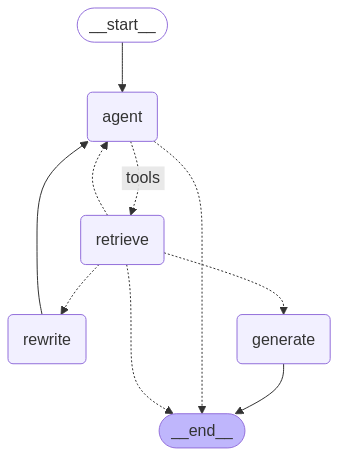

In [27]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    pass

In [28]:
import pprint

inputs = {
    "messages": [
        ("user", "What are the 5 pointers to make a human live happy life ?"),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---CALL AGENT---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_gaspymERVtABYpolaCasRj1c', 'function': {'arguments': '{"query": "5 pointers to make a human live a happy life"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}, {'id': 'call_b3K5nfpCrqtEaSNnCvkkaAHg', 'function': {'arguments': '{"query": "tips for a happy life"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 59, 'prompt_tokens': 74, 'total_tokens': 133, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BHEGtV0nrfeKmHMFjbyZeA0F9qCq6', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-7598b44f-c89c-4be1-b967-3bcbc9a0140b-0', to

/usr/local/lib/python3.11/dist-packages/langchain_openai/chat_models/base.py:1582: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


---DECISION: DOCS RELEVANT---
"Output from node 'retrieve':"
'---'
{ 'messages': [ ToolMessage(content="Move closer to work (or work from home)\nSpend time with friends and family\nGet outside somewhere green\nHelp others to help yourself\nPractice smiling ‚Äî it can alleviate pain\nPlan a trip ‚Äî you don‚Äôt even need to take it\nMeditate ‚Äî rewire your brain for happiness\nPractice gratitude to increase both happiness and life satisfaction\nTailor this list to suit you\n\nmind-blowing what this can do to us.10. Practice gratitude to increase both happiness and life satisfactionThis is a seemingly simple strategy, but I‚Äôve personally found it to make a huge difference to my outlook. There are lots of ways to practice gratitude, from keeping a journal of things you‚Äôre grateful for, sharing three good things that happen each day with a friend or your partner, and going out of your way to show gratitude when others\n\nup-to-date version. No surprise then that I thought it would be 

/usr/local/lib/python3.11/dist-packages/langsmith/client.py:277: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


"Output from node 'generate':"
'---'
{ 'messages': [ 'The 5 pointers to make a human live a happy life are '
                'practicing gratitude, spending time with friends and family, '
                'getting outside in nature, helping others, and practicing '
                'smiling. These activities can increase happiness and life '
                'satisfaction. Meditation and planning a trip can also '
                'contribute to rewiring the brain for happiness.']}
'\n---\n'
